#  Ames House Sales Price Prediction using LR and One Hot Encoding

## Question 1

* Import the data using Pandas and examine the shape. There are 79 feature columns plus the predictor, the sale price (`SalePrice`). 
* There are three different types: integers (`int64`), floats (`float64`), and strings (`object`, categoricals). Examine how many there are of each data type. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('d:\\Machine Learning\\data\\house.csv')
print(data.shape)

(1379, 80)


In [4]:
data.dtypes.value_counts()

object     43
float64    21
int64      16
dtype: int64

## Question 2

As discussed in the lecture, a significant challenge, particularly when dealing with data that have many columns, is ensuring each column gets encoded correctly. 

This is particularly true with data columns that are ordered categoricals (ordinals) vs unordered categoricals. Unordered categoricals should be one-hot encoded, however this can significantly increase the number of features and creates features that are highly correlated with each other.

Determine how many total features would be present, relative to what currently exists, if all string (object) features are one-hot encoded. Recall that the total number of one-hot encoded columns is `n-1`, where `n` is the number of categories.

In [5]:
# Select the object (string) columns
mask = data.dtypes == np.object
categorical_cols = data.columns[mask]

In [6]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

215

## Question 3

Let's create a new data set where all of the above categorical features will be one-hot encoded. We can fit this data and see how it affects the results.

* Used the dataframe `.copy()` method to create a completely separate copy of the dataframe for one-hot encoding
* On this new dataframe, one-hot encode each of the appropriate columns and add it back to the dataframe. Be sure to drop the original column.
* For the data that are not one-hot encoded, drop the columns that are string categoricals.

For the first step, numerically encoding the string categoricals, either Scikit-learn;s `LabelEncoder` or `DictVectorizer` can be used. However, the former is probably easier since it doesn't require specifying a numerical value for each category, and we are going to one-hot encode all of the numerical values anyway. (Can you think of a time when `DictVectorizer` might be preferred?)

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

## Question 4

* Create train and test splits.
* Fit a basic linear regression model on the training data. 
* Calculate the mean squared error for train and test sets.

In [8]:
from sklearn.model_selection import train_test_split

y_col = 'SalePrice'

# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

train_mse = mean_squared_error(y_train_ohc, y_train_ohc_pred)
test_mse = mean_squared_error(y_test_ohc,  y_test_ohc_pred)

print('Training MSE: ', train_mse)
print('Test MSE: ', test_mse)

Training MSE:  317730252.95261407
Test MSE:  3.1805918721620763e+19


Note that the error values on the one-hot encoded data are very different for the train and test data. In particular, the errors on the test data are much higher. Based on the lecture, this is because the one-hot encoded model is overfitting the data. We will learn how to deal with issues like this in the next lesson.

## Question 5

For the data set one-hot encoded:

* Scale using `StandardScaler`, `MinMaxScaler`
* Compare the error calculated on the test sets

Be sure to calculate the skew (to decide if a transformation should be done) and fit the scaler on *ONLY* the training data, but then apply it to both the train and test data identically.

In [10]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

stdscaler = StandardScaler()

# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train_ohc.dtypes == np.float
float_columns = X_train_ohc.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors

trainingset = X_train_ohc.copy()  # copy because we dont want to scale this more than once.
testset = X_test_ohc.copy()

trainingset[float_columns] = stdscaler.fit_transform(trainingset[float_columns])
testset[float_columns] = stdscaler.transform(testset[float_columns])

LR.fit(trainingset, y_train_ohc)
predictions = LR.predict(testset)

mse = mean_squared_error(y_test_ohc, predictions)
print("MSE One Hot Coding with Standard Scaling: ", mse)

MSE One Hot Coding with Standard Scaling:  9.293838382951562e+28


## Question 6

Plot predictions vs actual for one of the models.

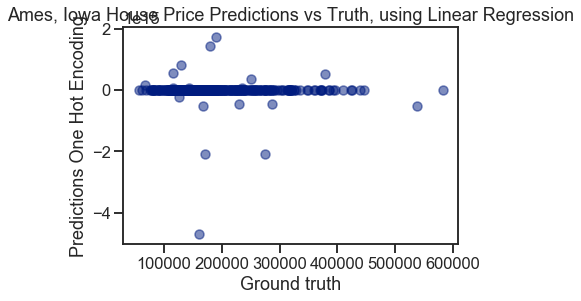

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, predictions, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions One Hot Encoding',
       title='Ames, Iowa House Price Predictions vs Truth, using Linear Regression');